<a href="https://colab.research.google.com/github/ferngonzalezp/Langevin-GAN/blob/master/wgan_langevin_pytroch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [92]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [0]:

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 200

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 500

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.0

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

clip_value = 0.05

ncritic = 5

# Main parameter:


*   nPred : 1/4 number of succesive points to  predict (should be multiple of 4 due to successive convolution later on)
*    nPer: number of correlation time to consider
*    nRand: number of random number used to generate the signal

   

In [0]:
nPred=50 #x4 !
nPer= 4 
nRand=20
Tl = (0.05, 0.1, 1)

# To generate a time like turbulent signal 1D through a langevin equation

In [0]:
#Modules utilisés

import numpy as np
import matplotlib.pyplot as plt


#Resolution de l'équation de Langevin

def generateLangevin(LagrangeTime,nPerd,nPts,var,uIni=0.):
  v0=uIni
  vari=var
  TL=LagrangeTime
  t_depart=0.
  t_final=nPerd*TL
  N=nPts
  dt=(t_final-t_depart)/N
  t=np.linspace(t_depart,t_final,N)

  Csta=1./TL
  Cstb=Csta*2*vari

  val_u=[v0] #liste qui va contenir les valeurs de vitesse
    
  for i in range(1,N):
    val_u.append(val_u[i-1]-Csta*val_u[i-1]*dt+np.sqrt(Cstb*dt)*np.random.normal(0,1)) 
  return val_u

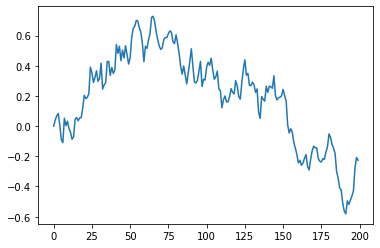

In [96]:
u=generateLangevin(.05,nPer,nPred*4,0.1)
plt.plot(u)

In [97]:

BUFFER_SIZE = 5000
BATCH_SIZE = batch_size

train_sigs=[]
labels = []
for j in range(len(Tl)) :
  for i in range(BUFFER_SIZE) :
    train_sigs.append(generateLangevin(Tl[j],nPer,nPred*4,0.1))
    labels.append(Tl[j])
train_sigs=np.array(train_sigs)
labels = np.array(labels)
print(train_sigs.shape)

train_sigs = train_sigs.reshape(train_sigs.shape[0], nPred*4, 1, 1).astype('float32')
print(train_sigs.shape)
print(labels.shape)



(15000, 200)
(15000, 200, 1, 1)
(15000,)


In [98]:
labels[:19]

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [0]:
#Create Dataset
train_sigs = torch.tensor(train_sigs)
labels = torch.tensor(labels, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(train_sigs,labels)
#Create DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True)

In [0]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.fc = nn.Sequential(
            nn.Linear(1,1,bias=False),
            nn.LeakyReLU(True)
        )
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nPred*4+1, ngf*4,(5,1), (2,1),(2,0), bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.LeakyReLU(0.2,True),
            # state size. (ngf*4) x 1 x 1
            nn.ConvTranspose2d(ngf*4,ngf*2, (5,1), (2,1),(2,0), bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.LeakyReLU(0.2,True),
            # state size. (ngf*2) x 1 x 1
            nn.ConvTranspose2d(ngf*2,ngf, (5,1), (2,1),(2,0), bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2,True),
            # state size. ngf x 1 x 1
            nn.ConvTranspose2d( ngf, nPred*4,(5,1), (2,1),(2,0), bias=False),
            nn.Tanh()
            # state size. (nz) x 1 x 1
        )

    def forward(self, noise, label):
        l_size = label.size()
        label = torch.reshape(label,(l_size[0],1))
        label = torch.reshape(self.fc(label),(l_size[0],1,1,1))
        noise = torch.cat((noise,label),dim=1)
        return self.main(noise)

In [103]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=False)
    (1): LeakyReLU(negative_slope=True)
  )
  (main): Sequential(
    (0): ConvTranspose2d(201, 256, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(64, 200, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0), bias=False)
    (10): Tanh()
  )
)


In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.fc = nn.Sequential(
            nn.Linear(1,1,bias=False),
            nn.LeakyReLU(True)
        )
        self.main = nn.Sequential(
            # input is nz x 1 x 1
            nn.utils.spectral_norm(nn.Conv2d(nPred*4+1, ndf * 4, (5,1), (2,1), (2,0), bias=False)),
            nn.LeakyReLU(0.2,inplace=True),
            # state size. (ndf*2) x 1 x 1
            nn.utils.spectral_norm(nn.Conv2d(ndf * 4, ndf * 2, (5,1), (2,1), (2,0), bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2,inplace=True),
            # state size. (ndf*4) x 1 x 1
            nn.utils.spectral_norm(nn.Conv2d(ndf * 2, ndf, (5,1), (2,1), (2,0), bias=False)),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2,inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(ndf, 1, (5,1), (2,1), (2,0), bias=False)),
 
        )

    def forward(self, noise,label):
        l_size = label.size()
        label = torch.reshape(label,(l_size[0],1))
        label = torch.reshape(self.fc(label),(l_size[0],1,1,1))
        noise = torch.cat((noise,label),dim=1)
        return self.main(noise)

In [105]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=False)
    (1): LeakyReLU(negative_slope=True)
  )
  (main): Sequential(
    (0): Conv2d(201, 256, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(256, 128, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 64, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 1, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0), bias=False)
  )
)


In [0]:
# Initialize loss function
def criterion(y):
  return torch.mean(y)

# Setup Adam optimizers for both G and D
optimizerD =  optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [0]:
#D = netD(generated_sig,label.to(device))
#D[0,:19,:,:]

In [108]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data, classes) in enumerate(dataloader,0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        class_real = classes.to(device)
        b_size = real_cpu.size()
        # Forward pass real batch through D
        output = netD(real_cpu,class_real)
        # Calculate loss on all-real batch
        errD_real = criterion(output)
        D_x = errD_real.item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size[0], nPred*4, 1, 1, device=device)
        class_fake = class_real[torch.randperm(b_size[0])]
        # Generate fake image batch with G
        fake = netG(noise,class_fake)
        # Classify all fake batch with D
        output = netD(fake.detach(),class_real)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output)
        D_G_z1 = errD_fake.item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real - errD_fake
        errD.backward()
        # Update D
        optimizerD.step()
        # Clip weights of discriminator
        for p in netD.parameters():
            p.data.clamp_(-clip_value, clip_value)

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        if iters % ncritic == 0:
          netG.zero_grad()
          # Since we just updated D, perform another forward pass of all-fake batch through D
          output = netD(fake,class_real)
          # Calculate G's loss based on this output
          errG = criterion(output)
          # Calculate gradients for G
          errG.backward()
          D_G_z2 = errG.item()
          # Update G
          optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
            
        iters += 1

Starting Training Loop...
[0/500][0/118]	Loss_D: -0.0002	Loss_G: 0.0008	D(x): -0.0115	D(G(z)): -0.0113 / 0.0008
[0/500][50/118]	Loss_D: -0.0414	Loss_G: 0.0023	D(x): -0.0398	D(G(z)): 0.0016 / 0.0023
[0/500][100/118]	Loss_D: -0.0751	Loss_G: 0.0047	D(x): -0.0713	D(G(z)): 0.0038 / 0.0047
[1/500][0/118]	Loss_D: -0.0771	Loss_G: 0.0042	D(x): -0.0774	D(G(z)): -0.0003 / 0.0042
[1/500][50/118]	Loss_D: -0.0869	Loss_G: -0.0016	D(x): -0.0876	D(G(z)): -0.0007 / -0.0016
[1/500][100/118]	Loss_D: -0.0753	Loss_G: -0.0002	D(x): -0.0846	D(G(z)): -0.0093 / -0.0002
[2/500][0/118]	Loss_D: -0.0719	Loss_G: 0.0006	D(x): -0.0855	D(G(z)): -0.0136 / 0.0006
[2/500][50/118]	Loss_D: -0.0695	Loss_G: -0.0079	D(x): -0.0897	D(G(z)): -0.0201 / -0.0079
[2/500][100/118]	Loss_D: -0.0703	Loss_G: -0.0102	D(x): -0.0878	D(G(z)): -0.0175 / -0.0102
[3/500][0/118]	Loss_D: -0.0796	Loss_G: -0.0100	D(x): -0.0847	D(G(z)): -0.0051 / -0.0100
[3/500][50/118]	Loss_D: -0.0872	Loss_G: -0.0027	D(x): -0.0908	D(G(z)): -0.0036 / -0.0027
[3/500][

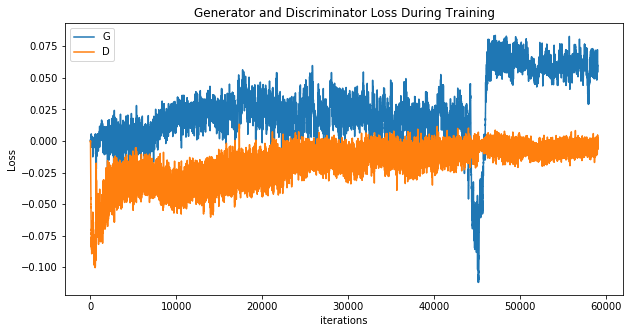

In [109]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
num_examples_to_generate = 5000
#Generate Langevin with Tl = 0.05
manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)
noise = torch.randn(num_examples_to_generate, nPred*4,1,1, device=device)
label = torch.tensor(np.ones(num_examples_to_generate)*Tl[0],dtype=torch.float)
label = label.to(device)
predicted_langevin_1 = netG(noise,label)
predicted_langevin_1 = predicted_langevin_1.cpu().detach().numpy()
#Generate Langevin with Tl = 0.1
manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)
noise = torch.randn(num_examples_to_generate, nPred*4,1,1, device=device)
label = torch.tensor(np.ones(num_examples_to_generate)*Tl[1],dtype=torch.float)
label = label.to(device)
predicted_langevin_2 = netG(noise,label)
predicted_langevin_2 = predicted_langevin_2.cpu().detach().numpy()
#Generate Langevin with Tl = 1
manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)
noise = torch.randn(num_examples_to_generate, nPred*4,1,1, device=device)
label = torch.tensor(np.ones(num_examples_to_generate)*Tl[2],dtype=torch.float)
label = label.to(device)
predicted_langevin_3 = netG(noise,label)
predicted_langevin_3 = predicted_langevin_3.cpu().detach().numpy()



In [0]:
t = np.linspace(0,4,nPred*4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
  del sys.path[0]


Text(0.5, 0, 't/Tl')

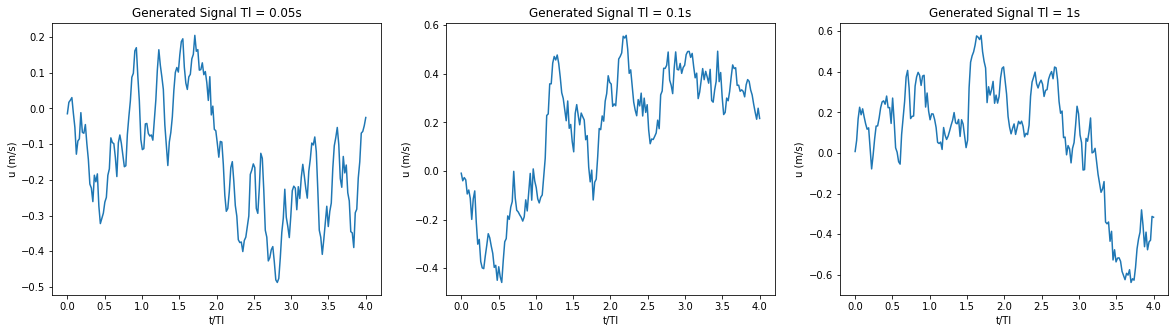

In [147]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(t,predicted_langevin_1[np.random.random_integers(0,4999),:,0,0])
plt.title("Generated Signal Tl = "+ str(Tl[0])+"s")
plt.ylabel("u (m/s)")
plt.xlabel("t/Tl")
plt.subplot(1,3,2)
plt.plot(t,predicted_langevin_2[np.random.random_integers(0,4999),:,0,0])
plt.title("Generated Signal Tl = "+ str(Tl[1])+"s")
plt.ylabel("u (m/s)")
plt.xlabel("t/Tl")
plt.subplot(1,3,3)
plt.plot(t,predicted_langevin_3[np.random.random_integers(0,4999),:,0,0])
plt.title("Generated Signal Tl = "+ str(Tl[2])+"s")
plt.ylabel("u (m/s)")
plt.xlabel("t/Tl")


Text(0.5, 0, 't/Tl')

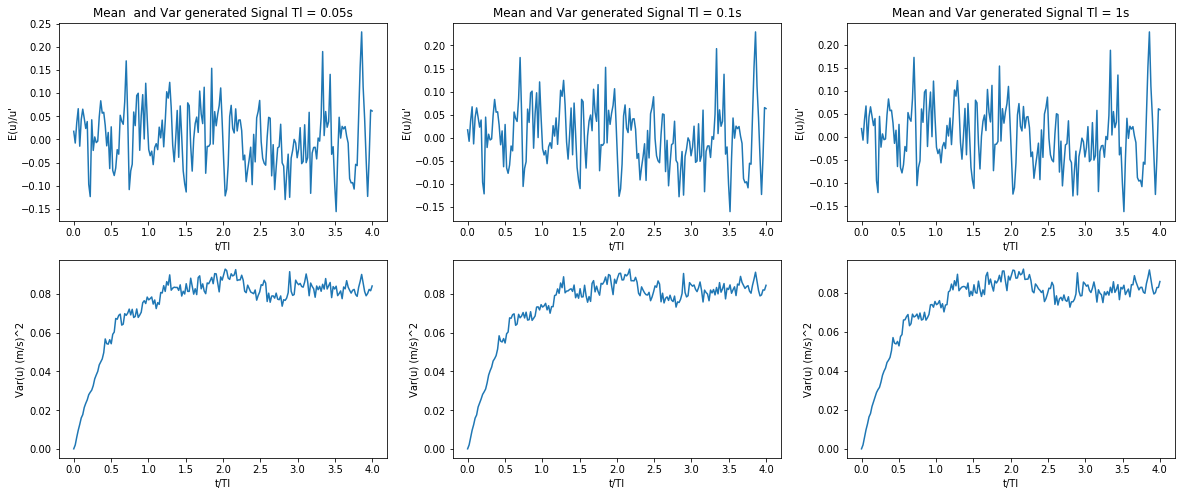

In [166]:
plt.figure(figsize=(20,8))
mean_gen = np.zeros(nPred*4)
var_gen = np.zeros(nPred*4)
for i  in range(0,num_examples_to_generate):
    mean_gen = mean_gen+ predicted_langevin_1[i,:,0,0]
    var_gen = var_gen + predicted_langevin_1[i,:,0,0]**2

mean_gen = mean_gen/num_examples_to_generate
var_gen1 = var_gen/num_examples_to_generate-mean_gen**2
mean_gen = mean_gen/np.sqrt(.1)

plt.subplot(2,3,1)
plt.plot(t,mean_gen)
plt.title("Mean  and Var generated Signal Tl = "+ str(Tl[0])+"s")
plt.ylabel("E(u)/u'")
plt.xlabel("t/Tl")
plt.subplot(2,3,4)
plt.plot(t,var_gen1)
plt.ylabel("Var(u) (m/s)^2")
plt.xlabel("t/Tl")

mean_gen = np.zeros(nPred*4)
var_gen = np.zeros(nPred*4)
for i  in range(0,num_examples_to_generate):
    mean_gen = mean_gen+ predicted_langevin_2[i,:,0,0]
    var_gen = var_gen + predicted_langevin_2[i,:,0,0]**2

mean_gen = mean_gen/num_examples_to_generate
var_gen2 = var_gen/num_examples_to_generate-mean_gen**2
mean_gen = mean_gen/np.sqrt(.1)
plt.subplot(2,3,2)
plt.plot(t,mean_gen)
plt.title("Mean and Var generated Signal Tl = "+ str(Tl[1])+"s")
plt.ylabel("E(u)/u'")
plt.xlabel("t/Tl")
plt.subplot(2,3,5)
plt.plot(t,var_gen2)
plt.ylabel("Var(u) (m/s)^2")
plt.xlabel("t/Tl")

mean_gen = np.zeros(nPred*4)
var_gen = np.zeros(nPred*4)
for i  in range(0,num_examples_to_generate):
    mean_gen = mean_gen+ predicted_langevin_3[i,:,0,0]
    var_gen = var_gen + predicted_langevin_3[i,:,0,0]**2

mean_gen = mean_gen/num_examples_to_generate
var_gen3 = var_gen/num_examples_to_generate-mean_gen**2
mean_gen = mean_gen/np.sqrt(.1)
plt.subplot(2,3,3)
plt.plot(t,mean_gen)
plt.title("Mean and Var generated Signal Tl = "+ str(Tl[2])+"s")
plt.ylabel("E(u)/u'")
plt.xlabel("t/Tl")
plt.subplot(2,3,6)
plt.plot(t,var_gen3)
plt.ylabel("Var(u) (m/s)^2")
plt.xlabel("t/Tl")

In [113]:
var_mean = np.var(mean_gen)
print(var_mean)

0.004269672122572025


In [168]:
max(var_gen1)

0.09266761006621142

In [0]:
def auto_cor(v):
  result = np.correlate(v,v,mode='full')
  return result/result.max()

Text(0.5, 0, 'tau (s)')

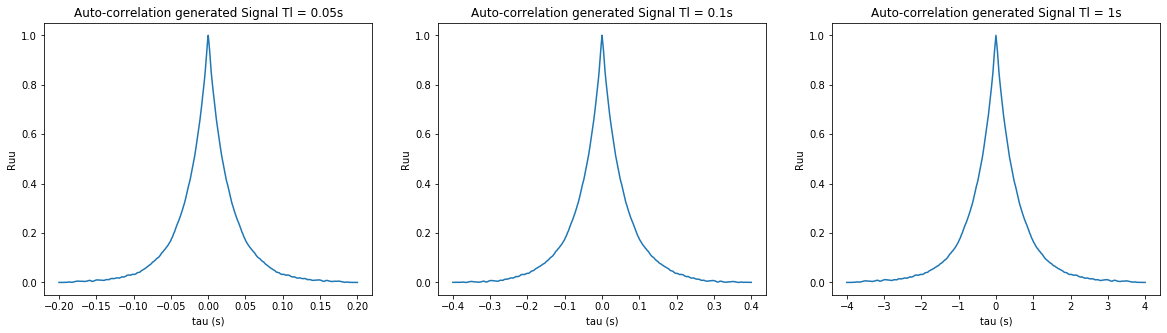

In [151]:
plt.figure(figsize=(20,5))
Ruu = np.array(0);
for i in range(num_examples_to_generate):
  Ruu = Ruu + auto_cor(predicted_langevin_1[i,:,0,0])
Ruu_1 = Ruu/num_examples_to_generate
plt.subplot(1,3,1)
plt.plot(np.linspace(-Tl[0]*nPer,Tl[0]*nPer,nPred*2*nPer-1),Ruu_1)
plt.title("Auto-correlation generated Signal Tl = "+ str(Tl[0])+"s")
plt.ylabel("Ruu")
plt.xlabel("tau (s)")
Ruu = np.array(0);
for i in range(num_examples_to_generate):
  Ruu = Ruu + auto_cor(predicted_langevin_2[i,:,0,0])
Ruu_2 = Ruu/num_examples_to_generate
plt.subplot(1,3,2)
plt.plot(np.linspace(-Tl[1]*nPer,Tl[1]*nPer,nPred*2*nPer-1),Ruu_2)
plt.title("Auto-correlation generated Signal Tl = "+ str(Tl[1])+"s")
plt.ylabel("Ruu")
plt.xlabel("tau (s)")
Ruu = np.array(0);
for i in range(num_examples_to_generate):
  Ruu = Ruu + auto_cor(predicted_langevin_3[i,:,0,0])
Ruu_3 = Ruu/num_examples_to_generate
plt.subplot(1,3,3)
plt.plot(np.linspace(-Tl[2]*nPer,Tl[2]*nPer,nPred*2*nPer-1),Ruu_3)
plt.title("Auto-correlation generated Signal Tl = "+ str(Tl[2])+"s")
plt.ylabel("Ruu")
plt.xlabel("tau (s)")

In [116]:
Tl_emp1 = np.trapz(Ruu_1,np.linspace(-Tl[0]*nPer,Tl[0]*nPer,nPred*2*nPer-1))
Tl_emp2 = np.trapz(Ruu_2,np.linspace(-Tl[1]*nPer,Tl[1]*nPer,nPred*2*nPer-1))
Tl_emp3 = np.trapz(Ruu_3,np.linspace(-Tl[2]*nPer,Tl[2]*nPer,nPred*2*nPer-1))
print(Tl_emp1,Tl_emp2,Tl_emp3)


0.056275288133057724 0.11365450874103197 1.1435542397599447


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning:

Text(0.5, 1.0, 'PDF generated Signal Tl = 1s')

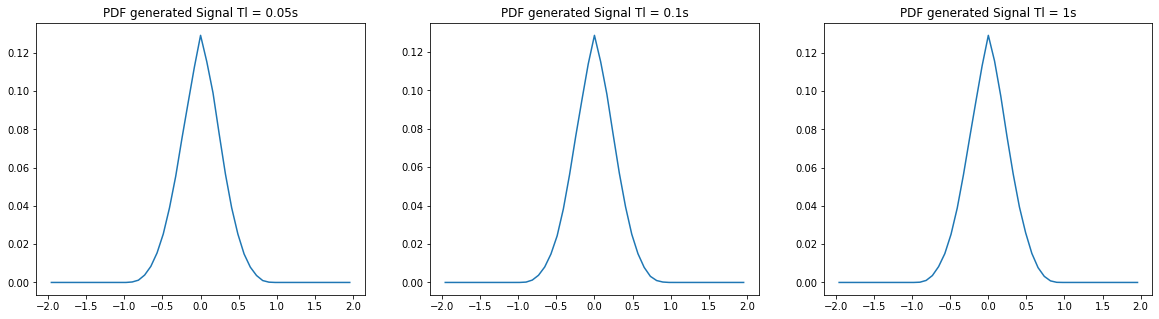

In [152]:
plt.figure(figsize=(20,5))
bins = np.linspace(-2,2,50)
hist_1,_ = np.histogram(predicted_langevin_1,bins = bins,normed=True)
hist_1 = hist_1/np.sum(hist_1)
plt.subplot(1,3,1)
plt.plot((bins[1:] + bins[:-1]) / 2,hist_1)
plt.title("PDF generated Signal Tl = "+ str(Tl[0])+"s")
hist_2,_ = np.histogram(predicted_langevin_2,bins = bins,normed=True)
hist_2 = hist_2/np.sum(hist_2)
plt.subplot(1,3,2)
plt.plot((bins[1:] + bins[:-1]) / 2,hist_2)
plt.title("PDF generated Signal Tl = "+ str(Tl[1])+"s")
hist_3,_ = np.histogram(predicted_langevin_3,bins = bins,normed=True)
hist_3 = hist_3/np.sum(hist_3)
plt.subplot(1,3,3)
plt.plot((bins[1:] + bins[:-1]) / 2,hist_3)
plt.title("PDF generated Signal Tl = "+ str(Tl[2])+"s")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
  app.launch_new_instance()


Text(0.5, 0, 't/Tl')

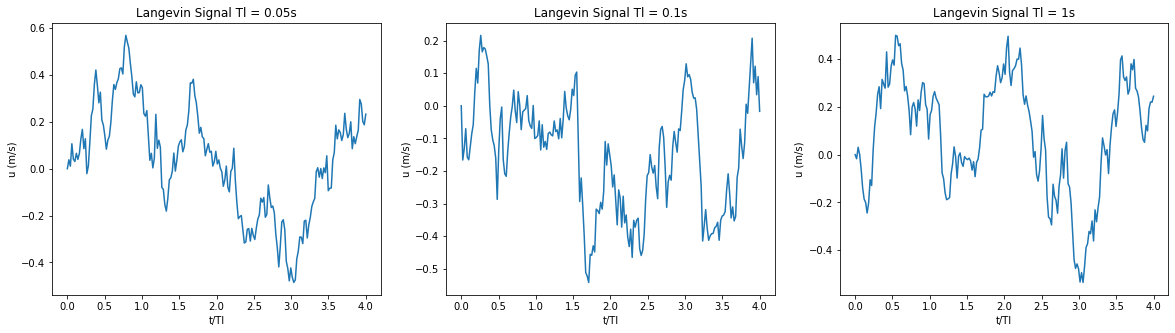

In [153]:
plt.figure(figsize=(20,5))
langevin_1 = train_sigs[0:5000].cpu().detach().numpy()
plt.subplot(1,3,1)
plt.plot(t,langevin_1[np.random.random_integers(0,4999),:,0,0])
plt.title("Langevin Signal Tl = "+ str(Tl[0])+"s")
plt.ylabel("u (m/s)")
plt.xlabel("t/Tl")
langevin_2 = train_sigs[5000:10000].cpu().detach().numpy()
plt.subplot(1,3,2)
plt.plot(t,langevin_2[np.random.random_integers(0,4999),:,0,0])
plt.title("Langevin Signal Tl = "+ str(Tl[1])+"s")
plt.ylabel("u (m/s)")
plt.xlabel("t/Tl")
langevin_3 = train_sigs[10000:15000].cpu().detach().numpy()
plt.subplot(1,3,3)
plt.plot(t,langevin_3[np.random.random_integers(0,4999),:,0,0])
plt.title("Langevin Signal Tl = "+ str(Tl[2])+"s")
plt.ylabel("u (m/s)")
plt.xlabel("t/Tl")

Text(0.5, 0, 't/Tl')

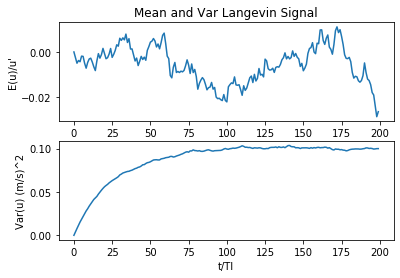

In [167]:
mean_gen = np.zeros(nPred*4)
var_gen = np.zeros(nPred*4)
for i  in range(0,num_examples_to_generate):
    mean_gen = mean_gen+ langevin_1[i,:,0,0]
    var_gen = var_gen + langevin_1[i,:,0,0]**2

mean_gen = mean_gen/num_examples_to_generate
var_gen = var_gen/num_examples_to_generate-mean_gen**2
mean_gen = mean_gen/np.sqrt(.1)
plt.subplot(2,1,1)
plt.plot(mean_gen)
plt.title("Mean and Var Langevin Signal")
plt.ylabel("E(u)/u'")
plt.xlabel("t/Tl")
plt.subplot(2,1,2)
plt.plot(var_gen)
plt.ylabel("Var(u) (m/s)^2")
plt.xlabel("t/Tl")

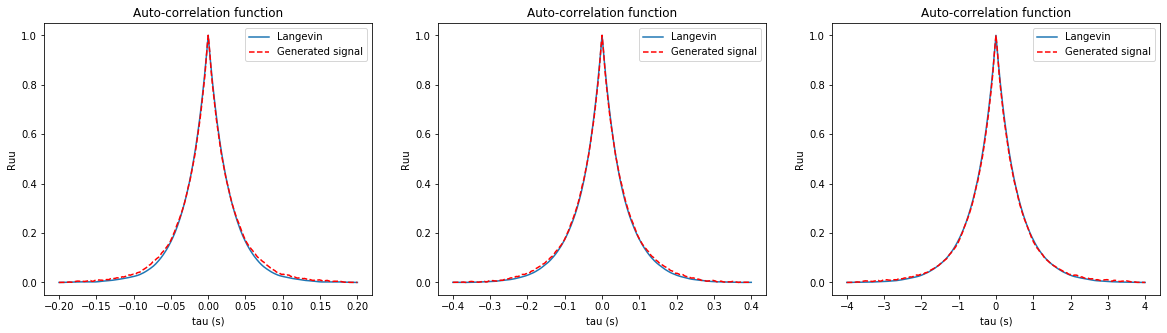

In [161]:
plt.figure(figsize=(20,5))
Ruu_real = np.array(0);
for i in range(num_examples_to_generate):
  Ruu_real = Ruu_real + auto_cor(langevin_1[i,:,0,0])
Ruu_real = Ruu_real/num_examples_to_generate
plt.subplot(1,3,1)
plt.title('Auto-correlation function')
plt.plot(np.linspace(-Tl[0]*nPer,Tl[0]*nPer,nPred*2*nPer-1),Ruu_real,label='Langevin')
plt.plot(np.linspace(-Tl[0]*nPer,Tl[0]*nPer,nPred*2*nPer-1),Ruu_1,'r--',label='Generated signal')
plt.ylabel("Ruu")
plt.xlabel("tau (s)")
plt.legend()

Ruu_real = np.array(0);
for i in range(num_examples_to_generate):
  Ruu_real = Ruu_real + auto_cor(langevin_2[i,:,0,0])
Ruu_real = Ruu_real/num_examples_to_generate
plt.subplot(1,3,2)
plt.title('Auto-correlation function')
plt.plot(np.linspace(-Tl[1]*nPer,Tl[1]*nPer,nPred*2*nPer-1),Ruu_real,label='Langevin')
plt.plot(np.linspace(-Tl[1]*nPer,Tl[1]*nPer,nPred*2*nPer-1),Ruu_2,'r--',label='Generated signal')
plt.ylabel("Ruu")
plt.xlabel("tau (s)")
plt.legend()

Ruu_real = np.array(0);
for i in range(num_examples_to_generate):
  Ruu_real = Ruu_real + auto_cor(langevin_3[i,:,0,0])
Ruu_real = Ruu_real/num_examples_to_generate
plt.subplot(1,3,3)
plt.title('Auto-correlation function')
plt.plot(np.linspace(-Tl[2]*nPer,Tl[2]*nPer,nPred*2*nPer-1),Ruu_real,label='Langevin')
plt.plot(np.linspace(-Tl[2]*nPer,Tl[2]*nPer,nPred*2*nPer-1),Ruu_3,'r--',label='Generated signal')
plt.ylabel("Ruu")
plt.xlabel("tau (s)")
plt.legend()
plt.show()

In [121]:
Tl_emp1 = np.trapz(Ruu_real,np.linspace(-Tl[0]*nPer,Tl[0]*nPer,nPred*8-1))
Tl_emp2 = np.trapz(Ruu_real,np.linspace(-Tl[1]*nPer,Tl[1]*nPer,nPred*8-1))
Tl_emp3 = np.trapz(Ruu_real,np.linspace(-Tl[2]*nPer,Tl[2]*nPer,nPred*8-1))
print(Tl_emp1,Tl_emp2,Tl_emp3)

0.056282503301994816 0.11256500660398963 1.1256500660398965


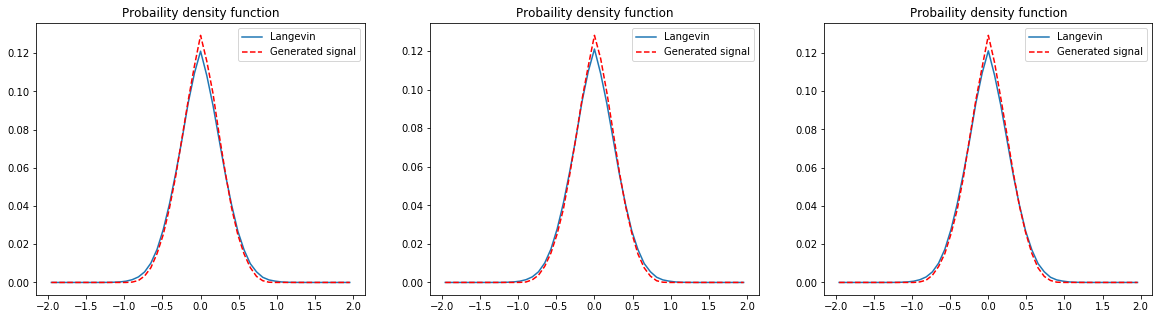

In [122]:
plt.figure(figsize=(20,5))
bins = np.linspace(-2,2,50)
hist_real,_ = np.histogram(langevin_1,bins = bins,density=True)
hist_real = hist_real/np.sum(hist_real)
plt.subplot(1,3,1)
plt.plot((bins[1:] + bins[:-1]) / 2,hist_real,label='Langevin')
plt.plot((bins[1:] + bins[:-1]) / 2,hist_1,'r--',label='Generated signal')
plt.title('Probaility density function')
plt.legend()


plt.subplot(1,3,2)
plt.plot((bins[1:] + bins[:-1]) / 2,hist_real,label='Langevin')
plt.plot((bins[1:] + bins[:-1]) / 2,hist_2,'r--',label='Generated signal')
plt.title('Probaility density function')
plt.legend()


plt.subplot(1,3,3)
plt.plot((bins[1:] + bins[:-1]) / 2,hist_real,label='Langevin')
plt.plot((bins[1:] + bins[:-1]) / 2,hist_3,'r--',label='Generated signal')
plt.title('Probaility density function')
plt.legend()
plt.show()

In [0]:
def jsd(q,p):
  kldiv = nn.KLDivLoss(reduction='mean')
  p = p + 1e-7
  q = q + 1e-7
  M = (p+q)/2

  jsd = 0.5*kldiv(torch.tensor(p).log(),torch.tensor(M)) + 0.5*kldiv(torch.tensor(q).log(),torch.tensor(M)) 
  print(jsd)
  return jsd

In [124]:
jsd(hist_1,hist_real)
jsd(hist_2,hist_real)
jsd(hist_3,hist_real)

tensor(0.0001, dtype=torch.float64)
tensor(9.3584e-05, dtype=torch.float64)
tensor(8.0583e-05, dtype=torch.float64)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


tensor(8.0583e-05, dtype=torch.float64)

#Interpolating Signals with new Time scales

In [0]:
Tl_new = np.array([0.03,0.7,1.5])

#Generate Langevin with Tl = 0.03
noise = torch.randn(num_examples_to_generate, nPred*4,1,1, device=device)
label = torch.tensor(np.ones(num_examples_to_generate)*Tl_new[0],dtype=torch.float)
label = label.to(device)
predicted_langevin_1 = netG(noise,label)
predicted_langevin_1 = predicted_langevin_1.cpu().detach().numpy()
#Generate Langevin with Tl = 0.7
noise = torch.randn(num_examples_to_generate, nPred*4,1,1, device=device)
label = torch.tensor(np.ones(num_examples_to_generate)*Tl_new[1],dtype=torch.float)
label = label.to(device)
predicted_langevin_2 = netG(noise,label)
predicted_langevin_2 = predicted_langevin_2.cpu().detach().numpy()
#Generate Langevin with Tl = 1.5
noise = torch.randn(num_examples_to_generate, nPred*4,1,1, device=device)
label = torch.tensor(np.ones(num_examples_to_generate)*Tl_new[2],dtype=torch.float)
label = label.to(device)
predicted_langevin_3 = netG(noise,label)
predicted_langevin_3 = predicted_langevin_3.cpu().detach().numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 4999 + 1) instead
  import sys


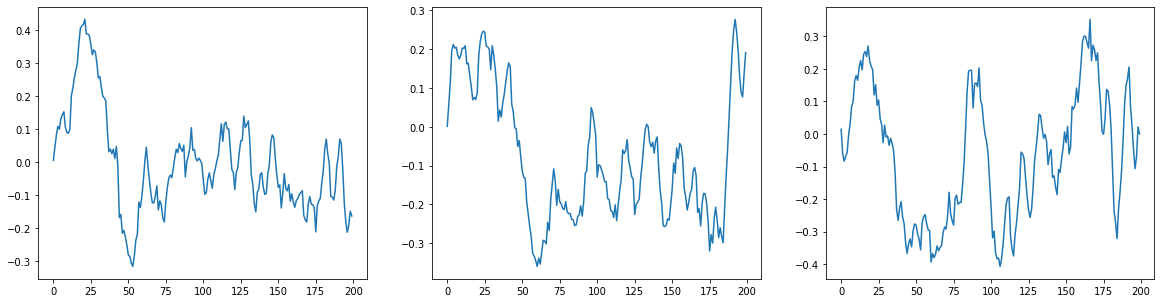

In [126]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(predicted_langevin_1[np.random.random_integers(0,4999),:,0,0])
plt.subplot(1,3,2)
plt.plot(predicted_langevin_2[np.random.random_integers(0,4999),:,0,0])
plt.subplot(1,3,3)
plt.plot(predicted_langevin_3[np.random.random_integers(0,4999),:,0,0])

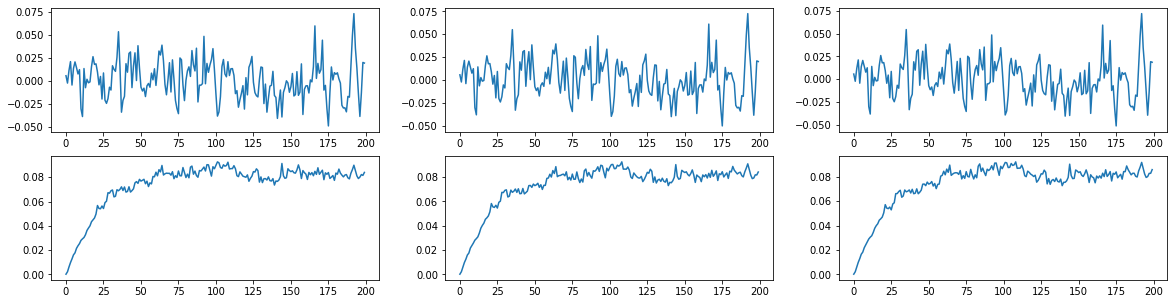

In [127]:
plt.figure(figsize=(20,5))
mean_gen = np.zeros(nPred*4)
var_gen = np.zeros(nPred*4)
for i  in range(0,num_examples_to_generate):
    mean_gen = mean_gen+ predicted_langevin_1[i,:,0,0]
    var_gen = var_gen + predicted_langevin_1[i,:,0,0]**2

mean_gen = mean_gen/num_examples_to_generate
var_gen1 = var_gen/num_examples_to_generate-mean_gen**2
plt.subplot(2,3,1)
plt.plot(mean_gen)
plt.subplot(2,3,4)
plt.plot(var_gen1)

mean_gen = np.zeros(nPred*4)
var_gen = np.zeros(nPred*4)
for i  in range(0,num_examples_to_generate):
    mean_gen = mean_gen+ predicted_langevin_2[i,:,0,0]
    var_gen = var_gen + predicted_langevin_2[i,:,0,0]**2

mean_gen = mean_gen/num_examples_to_generate
var_gen2 = var_gen/num_examples_to_generate-mean_gen**2
plt.subplot(2,3,2)
plt.plot(mean_gen)
plt.subplot(2,3,5)
plt.plot(var_gen2)

mean_gen = np.zeros(nPred*4)
var_gen = np.zeros(nPred*4)
for i  in range(0,num_examples_to_generate):
    mean_gen = mean_gen+ predicted_langevin_3[i,:,0,0]
    var_gen = var_gen + predicted_langevin_3[i,:,0,0]**2

mean_gen = mean_gen/num_examples_to_generate
var_gen3 = var_gen/num_examples_to_generate-mean_gen**2
plt.subplot(2,3,3)
plt.plot(mean_gen)
plt.subplot(2,3,6)
plt.plot(var_gen3)

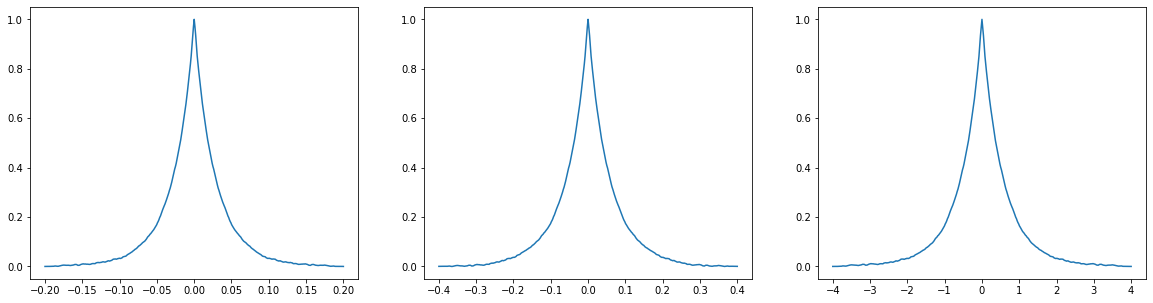

In [128]:
plt.figure(figsize=(20,5))
Ruu = np.array(0);
for i in range(num_examples_to_generate):
  Ruu = Ruu + auto_cor(predicted_langevin_1[i,:,0,0])
Ruu_1 = Ruu/num_examples_to_generate
plt.subplot(1,3,1)
plt.plot(np.linspace(-Tl[0]*nPer,Tl[0]*nPer,nPred*2*nPer-1),Ruu_1)
Ruu = np.array(0);
for i in range(num_examples_to_generate):
  Ruu = Ruu + auto_cor(predicted_langevin_2[i,:,0,0])
Ruu_2 = Ruu/num_examples_to_generate
plt.subplot(1,3,2)
plt.plot(np.linspace(-Tl[1]*nPer,Tl[1]*nPer,nPred*2*nPer-1),Ruu_2)
Ruu = np.array(0);
for i in range(num_examples_to_generate):
  Ruu = Ruu + auto_cor(predicted_langevin_3[i,:,0,0])
Ruu_3 = Ruu/num_examples_to_generate
plt.subplot(1,3,3)
plt.plot(np.linspace(-Tl[2]*nPer,Tl[2]*nPer,nPred*2*nPer-1),Ruu_3)

In [129]:
Tl_emp1 = np.trapz(Ruu_1,np.linspace(-Tl_new[0]*nPer,Tl_new[0]*nPer,nPred*2*nPer-1))
Tl_emp2 = np.trapz(Ruu_2,np.linspace(-Tl_new[1]*nPer,Tl_new[1]*nPer,nPred*2*nPer-1))
Tl_emp3 = np.trapz(Ruu_3,np.linspace(-Tl_new[2]*nPer,Tl_new[2]*nPer,nPred*2*nPer-1))
print(Tl_emp1,Tl_emp2,Tl_emp3)

0.034249114187272854 0.8053582866314912 1.6897577053358912


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: VisibleDeprecati

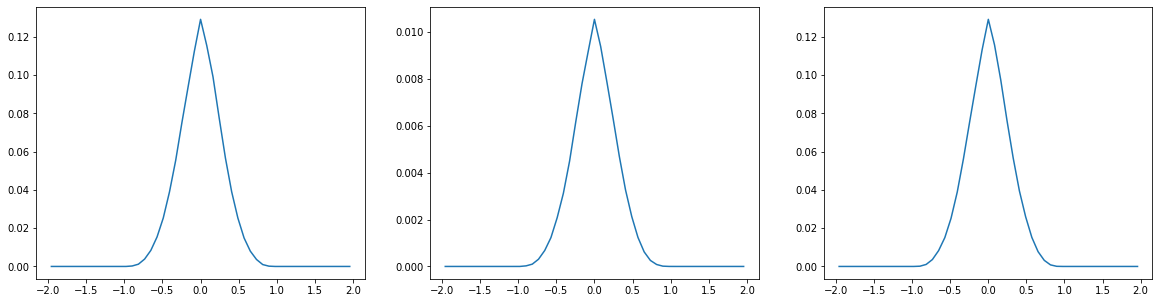

In [130]:
plt.figure(figsize=(20,5))
bins = np.linspace(-2,2,50)
hist_1,_ = np.histogram(predicted_langevin_1,bins = bins,normed=True)
hist_1 = hist_1/np.sum(hist_1)
plt.subplot(1,3,1)
plt.plot((bins[1:] + bins[:-1]) / 2,hist_1)
hist_2,_ = np.histogram(predicted_langevin_2,bins = bins,normed=True)
hist_2 = hist_3/np.sum(hist_2)
plt.subplot(1,3,2)
plt.plot((bins[1:] + bins[:-1]) / 2,hist_2)
hist_3,_ = np.histogram(predicted_langevin_3,bins = bins,normed=True)
hist_3 = hist_3/np.sum(hist_3)
plt.subplot(1,3,3)
plt.plot((bins[1:] + bins[:-1]) / 2,hist_3)

In [131]:
jsd(hist_1,hist_real)
jsd(hist_2,hist_real)
jsd(hist_3,hist_real)

tensor(0.0001, dtype=torch.float64)
tensor(0.0071, dtype=torch.float64)
tensor(0.0001, dtype=torch.float64)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


tensor(0.0001, dtype=torch.float64)